lets start with the modeling of a vortex

In [18]:
import numpy as np
import math
from matplotlib import pyplot
# embed the figures into the notebook
%matplotlib inline

## 1) import the correct airfoil

In [19]:
# load geometry from data file
naca_filepath = r'C:\Users\Ben\Documents\לימודים\שנה ד\סמסטר ב\אווירודינמיקה\קוד\IntroToAeroTau-main\notebooks\naca2412.dat'
with open(naca_filepath, 'r') as infile:
    x, y = numpy.loadtxt(infile, dtype=float, unpack=True)

(-0.05, 1.05, -0.048354999999999995, 0.084855)

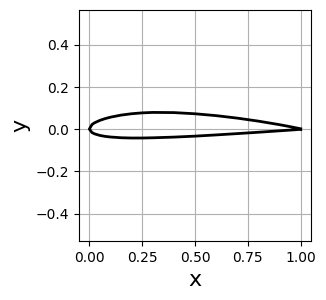

In [20]:
# plot geometry
width = 3
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1)
pyplot.axis('equal')

## 2) Add code from lessons

velocity and stream function for vortex

In [ ]:
def get_velocity_vortex(strength, xv, yv, X, Y):
    """
    Returns the velocity field generated by a vortex.

    Parameters
    ----------
    strength: float
        Strength of the vortex.
    xv: float
        x-coordinate of the vortex.
    yv: float
        y-coordinate of the vortex.
    X: 2D Numpy array of floats
        x-coordinate of the mesh points.
    Y: 2D Numpy array of floats
        y-coordinate of the mesh points.

    Returns
    -------
    u: 2D Numpy array of floats
        x-component of the velocity vector field.
    v: 2D Numpy array of floats
        y-component of the velocity vector field.
    """
    u = +strength / (2 * math.pi) * (Y - yv) / ((X - xv)**2 + (Y - yv)**2)
    v = -strength / (2 * math.pi) * (X - xv) / ((X - xv)**2 + (Y - yv)**2)

    return u, v
def get_stream_function_vortex(strength, xv, yv, X, Y):
    """
    Returns the stream-function generated by a vortex.

    Parameters
    ----------
    strength: float
        Strength of the vortex.
    xv: float
        x-coordinate of the vortex.
    yv: float
        y-coordinate of the vortex.
    X: 2D Numpy array of floats
        x-coordinate of the mesh points.
    Y: 2D Numpy array of floats
        y-coordinate of the mesh points.

    Returns
    -------
    psi: 2D Numpy array of floats
        The stream-function.
    """
    psi = strength / (4 * math.pi) * numpy.log((X - xv)**2 + (Y - yv)**2)

    return psi


panel creation: in this code i added the vortex panels

In [30]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the circulation, tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ---------_
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya  # panel starting-point
        self.xb, self.yb = xb, yb  # panel ending-point
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  # panel center
        self.length = numpy.sqrt((xb - xa)**2 + (yb - ya)**2)  # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.0:
            self.beta = numpy.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb - ya) / self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper'  # upper surface
        else:
            self.loc = 'lower'  # lower surface
        
        self.gamma = 0.0  # circulation strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient
        
    def influence(self, other):
        """
        Calculate the velocity influence of this panel on the control point of another panel.

        Parameters
        ----------
        other: Panel object
            The panel where the influence is being computed.

        Returns
        -------
        (u, v): tuple of floats
            Velocity components induced by this panel on the control point of another panel.
        """
        u, v = get_velocity_vortex(self.gamma, self.xc, self.yc, other.xc, other.yc)
        return u, v

In [22]:
def define_panels(x, y, N=40):
    """
    Discretizes the geometry into panels using 'cosine' method.
    
    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels;
        default: 40.
    
    Returns
    -------
    panels: 1D Numpy array of Panel objects.
        The list of panels.
    """
    
    R = (x.max() - x.min()) / 2.0  # circle radius
    x_center = (x.max() + x.min()) / 2.0  # x-coordinate of circle center
    
    theta = numpy.linspace(0.0, 2.0 * numpy.pi, N + 1)  # array of angles
    x_circle = x_center + R * numpy.cos(theta)  # x-coordinates of circle
    
    x_ends = numpy.copy(x_circle)  # x-coordinate of panels end-points
    y_ends = numpy.empty_like(x_ends)  # y-coordinate of panels end-points
    
    # extend coordinates to consider closed surface
    x, y = numpy.append(x, x[0]), numpy.append(y, y[0])
    
    # compute y-coordinate of end-points by projection
    I = 0
    for i in range(N):
        while I < len(x) - 1:
            if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
        b = y[I + 1] - a * x[I + 1]
        y_ends[i] = a * x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    # create panels
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])
    
    return panels


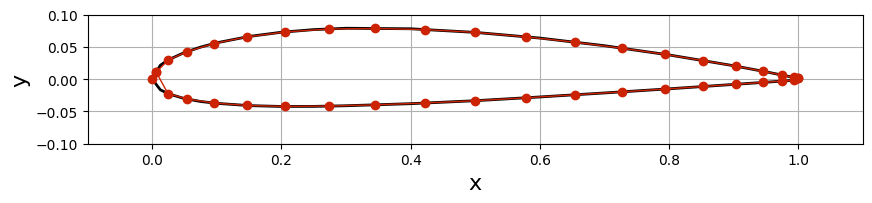

In [23]:
# discretize geoemetry into panels
panels = define_panels(x, y, N=40)
# plot discretized geometry
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x, y, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
            numpy.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
pyplot.axis('scaled')
pyplot.xlim(-0.1, 1.1)
pyplot.ylim(-0.1, 0.1);

freestream from class

In [27]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = numpy.radians(alpha)  # degrees to radians


# define freestream conditions
freestream = Freestream(u_inf=1.0, alpha=4.0)

Now that the influence function is set up, we will create a function to solve for the vortex strengths (gamma) by applying the boundary condition that the normal velocity on each panel should be zero (no flow through the panel).

In [31]:
def solve_vortex_strengths(panels, u_inf, alpha):
    """
    Solve for the vortex strengths (gamma) on each panel.

    Parameters
    ----------
    panels: list of Panel objects
        The panels of the airfoil.
    u_inf: float
        Freestream velocity.
    alpha: float
        Angle of attack in degrees.
    
    Returns
    -------
    numpy array of gamma values (circulations).
    """
    N = len(panels)
    A = numpy.zeros((N, N))  # coefficient matrix
    b = numpy.zeros(N)  # right-hand side vector

    # Fill the linear system
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            u_ij, v_ij = panel_j.influence(panel_i)
            A[i, j] = u_ij * numpy.cos(panel_i.beta) + v_ij * numpy.sin(panel_i.beta)
        b[i] = -u_inf * numpy.cos(alpha - panel_i.beta)

    # Solve the system of equations for gamma
    gamma = numpy.linalg.solve(A, b)
    
    # Update the gamma values for each panel
    for i, panel in enumerate(panels):
        panel.gamma = gamma[i]

    return gamma


Calculate Velocities and Pressure Coefficients

In [33]:
def compute_tangential_velocity(panels, u_inf, alpha):
    """
    Compute the tangential velocity at the control points of each panel.

    Parameters
    ----------
    panels: list of Panel objects
        The panels of the airfoil.
    u_inf: float
        Freestream velocity.
    alpha: float
        Angle of attack in degrees.
    """
    for i, panel_i in enumerate(panels):
        v_tangential = u_inf * numpy.sin(alpha - panel_i.beta)  # freestream contribution
        for j, panel_j in enumerate(panels):
            if i != j:
                u_ij, v_ij = panel_j.influence(panel_i)
                v_tangential += u_ij * numpy.sin(panel_i.beta) - v_ij * numpy.cos(panel_i.beta)
        panel_i.vt = v_tangential
def compute_pressure_coefficients(panels, u_inf):
    """
    Compute the pressure coefficient at the control points of each panel.

    Parameters
    ----------
    panels: list of Panel objects
        The panels of the airfoil.
    u_inf: float
        Freestream velocity.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / u_inf)**2  # Bernoulli's equation



## stage 3

first we will use the Blasius solution for boundary layer thickness:

In [34]:
def boundary_layer_thickness(x, Re_x):
    """
    Calculate the boundary layer thickness using the Blasius solution.

    Parameters:
    x : float
        Distance from the leading edge.
    Re_x : float
        Reynolds number based on distance x.

    Returns:
    float
        Boundary layer thickness.
    """
    return 5.0 * x / np.sqrt(Re_x)


Now we shall incorperate Viscous Effects 

In [26]:
def update_velocity_with_bl_effects(panels, u_freestream, nu):
    """
    Updates the velocity on each panel to account for boundary layer effects.

    Parameters:
    panels : list of Panel objects
        List of panels defining the airfoil.
    u_freestream : float
        Freestream velocity.
    nu : float
        Kinematic viscosity of the fluid.
    """
    for panel in panels:
        x_local = np.linspace(panel.xa, panel.xb, num=100)
        Re_x = u_freestream * x_local / nu
        delta = boundary_layer_thickness(x_local, Re_x)
        # Assume linear change in velocity across the boundary layer
        u_local = u_freestream * (1 - (delta / np.max(delta)))  # Simple linear profile
        # Update panel velocity
        panel.vt = np.mean(u_local)  # Example of updating velocity; adapt as needed

Apply Boundary Layer Corrections After Solving for the Vortex Strengths

In [ ]:
# After solving the vortex strengths and computing initial velocities
u_inf = 1.0  # Freestream velocity in your scenario
nu = 1.48e-5  # Kinematic viscosity of air (or another fluid depending on your setup)

# Update panel velocities to account for boundary layer effects
update_velocity_with_bl_effects(panels, u_inf, nu)

# Recalculate pressure coefficients
compute_pressure_coefficients(panels, u_inf)


Modifying the Lift and Drag Calculation

In [35]:
def compute_drag(panels, u_inf, chord_length):
    """
    Compute the drag force on the airfoil using the modified panel velocities.

    Parameters:
    -----------
    panels : list of Panel objects
        The panels of the airfoil.
    u_inf : float
        Freestream velocity.
    chord_length : float
        Chord length of the airfoil.

    Returns:
    --------
    float
        Drag coefficient.
    """
    drag_force = 0.0
    for panel in panels:
        # Compute force on each panel due to pressure difference
        drag_force += panel.cp * np.cos(panel.beta) * panel.length

    drag_coefficient = drag_force / (0.5 * u_inf**2 * chord_length)  # Normalize to coefficient
    return drag_coefficient


now we can check for correctness


In [36]:
# Discretize airfoil geometry into panels
panels = define_panels(x, y, N=40)

# Solve for vortex strengths
u_inf = 1.0  # Freestream velocity
alpha = np.radians(5.0)  # Angle of attack in radians
gamma = solve_vortex_strengths(panels, u_inf, alpha)

# Compute tangential velocities and pressure coefficients
compute_tangential_velocity(panels, u_inf, alpha)
compute_pressure_coefficients(panels, u_inf)

# Apply boundary layer corrections
update_velocity_with_bl_effects(panels, u_inf, nu)

# Recalculate pressure coefficients after boundary layer corrections
compute_pressure_coefficients(panels, u_inf)

# Compute drag based on updated pressure coefficients
chord_length = 1.0  # Example chord length
drag_coefficient = compute_drag(panels, u_inf, chord_length)

print(f'Drag Coefficient: {drag_coefficient}')


Drag Coefficient: nan


C:\Users\Ben\AppData\Local\Temp\ipykernel_31092\1690487789.py:25: RuntimeWarning: invalid value encountered in scalar divide
  u = +strength / (2 * math.pi) * (Y - yv) / ((X - xv)**2 + (Y - yv)**2)
C:\Users\Ben\AppData\Local\Temp\ipykernel_31092\1690487789.py:26: RuntimeWarning: invalid value encountered in scalar divide
  v = -strength / (2 * math.pi) * (X - xv) / ((X - xv)**2 + (Y - yv)**2)
C:\Users\Ben\AppData\Local\Temp\ipykernel_31092\3396068247.py:15: RuntimeWarning: invalid value encountered in divide
  return 5.0 * x / np.sqrt(Re_x)
